In [2]:
import numpy as np
import pandas as pd
import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector
from matplotlib import pyplot as plt
from IPython.display import display



def pol2cart(r, tet, phi):
    x = r*np.sin(tet)*np.cos(phi)
    y = r*np.sin(tet)*np.sin(phi)
    z = r*np.cos(tet)
    return x,y,z

def cart2pol(vec):
    x = vec[0]
    y = vec[1]
    z = vec[2]
    r = np.linalg.norm(vec)
    tet = np.arccos(z/r)
    phi = np.arctan(y/x)
    return r, tet, phi

def r_ort(tet, phi):
    x = np.sin(tet)*np.cos(phi)
    y = np.sin(tet)*np.sin(phi)
    z = np.cos(tet)
    return np.array([x, y, z])

def tet_ort(tet, phi):
    x = np.cos(tet)*np.cos(phi)
    y = np.cos(tet)*np.sin(phi)
    z = -np.sin(tet)
    return np.array([x, y, z])

def phi_ort(tet, phi):
    x = -np.sin(phi)
    y = np.cos(phi)
    z = 0
    return np.array([x, y, z])


In [3]:
class StationarMaterial:
    def __init__(self, Ms, gamma=5e8, alpha=0.018, Ku=6100.0, t=5e-9):
        self.Ms = Ms
        self.gamma = gamma
        self.alpha = alpha
        self.Ku = Ku
        self.t = t

        
class Material:
    def __init__(self, stationar):
        self.st = stationar
        
        self.Ms_l = lambda t: self.st.Ms
        self.gamma_l = lambda t: self.st.gamma
        self.alpha_l = lambda t: self.st.alpha
        self.Ku_l = lambda t: self.st.Ku
        self.t_l = lambda t: self.st.t
    
    def set_Ku_lambda(Ku_lambda):
        self.Ku_l = Ku_lambda

        
class LayeredFilm:
    def __init__(self, layer1, layer2, J):
        self.l1 = layer1
        self.l2 = layer2
        self.J = J

In [24]:
mu0 = 1.2566370621219e-6

uB_SI = 9.274009994e-24 #J/T
uB_CGS = 9.274009994e-21 #erg/G

hb_SI = 1.054571817e-34 # J*s
hb_CGS = 1.054571817e-27 #erg*s

g0_SI = uB_SI/hb_SI #1/(T*s)
g0_CGS = uB_CGS/hb_CGS #1/(G*s)


#estimate values from hysteresis loop
H_hyst_1 = 5502.528153752628
H_hyst_2 = 10874.775827050373
Ms_hyst = 480.
Ku1_hyst = 2*np.pi*(Ms_hyst**2) + H_hyst_1*Ms_hyst/2.
Ku2_hyst = 2*np.pi*(Ms_hyst**2) + H_hyst_1*Ms_hyst/2.
J_hyst = ((H_hyst_2-H_hyst_1) * Ms_hyst/2.)*12e-7

layer1 = Material(
    StationarMaterial(
        Ms=Ms_hyst, 
        gamma=2.2*g0_CGS, alpha=0.1,
        Ku=Ku1_hyst,
        t=12e-7
    )
)
layer2 = Material(
    StationarMaterial(
        Ms=Ms_hyst, 
        gamma=2.2*g0_CGS, alpha=0.1,
        Ku=Ku2_hyst,
        t=12e-7
    )
)
film_inst = LayeredFilm(layer1, layer2, J_hyst)

In [27]:
from scipy import optimize

class StationaryState:
    def __init__(self):
        S = CoordSys3D('S')
        Mx1, My1, Mz1 = symbols("M_x1 M_y1 M_z1")
        Mx2, My2, Mz2 = symbols("M_x2 M_y2 M_z2")
        M1 = Mx1*S.i + My1*S.j + Mz1*S.k
        M2 = Mx2*S.i + My2*S.j + Mz2*S.k
        
        Hx, Hy, Hz = symbols("H_x H_y H_z")
        H = Hx*S.i + Hy*S.j + Hz*S.k
        
        Ku1, Ku2, J = symbols("K_u1 K_u2 J")
        t1, t2 = symbols("t1 t2")
        
        self.Ze1 = -H.dot(M1)
        self.Ze2 = -H.dot(M2)
        
        self.SW_D1 = 0#u1*(Mx1**2 + My1**2)/(Mx1**2 + My1**2 + Mz1**2) + 2*sym.pi*(Mz1**2)
        self.SW_D2 = 0#u2*(Mx2**2 + My2**2)/(Mx2**2 + My2**2 + Mz2**2) + 2*sym.pi*(Mz2**2)
        
        self.Ev1 = self.Ze1 + self.SW_D1
        self.Ev2 = self.Ze2 + self.SW_D2
        
        self.Es = (J*M1.dot(M2)/(M1.magnitude()*M2.magnitude()) + t1*self.Ev1 + t2*self.Ev2)
        self.Heff_x1 = -self.Es.diff(Mx1)
        self.Heff_y1 = -self.Es.diff(My1)
        self.Heff_z1 = -self.Es.diff(Mz1)
        
        
        Ze1_varset = (
            Mx1, My1, Mz1,
            Hx, Hy, Hz
        )
        self.Ze1_lamb = lambdify(Ze1_varset, self.Ze1, 'numpy')
        
        Ze2_varset = (
            Mx2, My2, Mz2,
            Hx, Hy, Hz
        )
        self.Ze2_lamb = lambdify(Ze2_varset, self.Ze2, 'numpy')
        
        
        
        SW_D1_varset = (
            Mx1, My1, Mz1,
            Ku1
        )
        self.SW_D1_lamb = lambdify(SW_D1_varset, self.SW_D1, 'numpy')
        
        SW_D2_varset = (
            Mx2, My2, Mz2,
            Ku2
        )
        self.SW_D2_lamb = lambdify(SW_D2_varset, self.SW_D2, 'numpy')
        
        
        Ev1_varset = (
            Mx1, My1, Mz1,
            Hx, Hy, Hz,
            Ku1
        )
        
        self.Ev1_lamb = lambdify(Ev1_varset, self.Ev1, 'numpy')
        
        Ev2_varset = (
            Mx2, My2, Mz2,
            Hx, Hy, Hz,
            Ku2
        )
        
        self.Ev2_lamb = lambdify(Ev2_varset, self.Ev2, 'numpy')
        
        
        Es_varset = (
            Mx1, My1, Mz1,
            Mx2, My2, Mz2,
            Hx, Hy, Hz,
            Ku1, Ku2,
            J,
            t1, t2
        )
        
        self.Es_lamb = lambdify(Es_varset, self.Es, 'numpy')
    
        self.Heff_x1_lamb = lambdify(Es_varset, self.Heff_x1, 'numpy')
        self.Heff_y1_lamb = lambdify(Es_varset, self.Heff_y1, 'numpy')
        self.Heff_z1_lamb = lambdify(Es_varset, self.Heff_z1, 'numpy')
    
    def get_heff1(
        self,
        film,
        M1,
        M2,
        Hext
    ):
        return np.array([
            self.Heff_x1_lamb(
                M1[0], M1[1], M1[2],
                M2[0], M2[1], M2[2],
                Hext[0], Hext[1], Hext[2],
                film.l1.st.Ku, film.l2.st.Ku,
                film.J,
                film.l1.st.t, film.l2.st.t
            ),
            self.Heff_y1_lamb(
                M1[0], M1[1], M1[2],
                M2[0], M2[1], M2[2],
                Hext[0], Hext[1], Hext[2],
                film.l1.st.Ku, film.l2.st.Ku,
                film.J,
                film.l1.st.t, film.l2.st.t
            ),
            self.Heff_z1_lamb(
                M1[0], M1[1], M1[2],
                M2[0], M2[1], M2[2],
                Hext[0], Hext[1], Hext[2],
                film.l1.st.Ku, film.l2.st.Ku,
                film.J,
                film.l1.st.t, film.l2.st.t
            )
        ])
    
    def get_angles(
        self,
        film,
        Hext,
        tol = None,
        N = 10
    ):  
        func_l = lambda x: self.funcmin(x, film, Hext)
        
        best_res = 0
        min_E = 1e10
        for i in range(N):
            res = optimize.minimize(
                func_l, 
                #x0=np.random.uniform(size=(4,))*np.array([np.pi, 2*np.pi, np.pi, 2*np.pi]), 
                x0=np.array([0.0, 0.0, np.pi, 0.0]),
                bounds=[(0,2*np.pi),(0,2*2*np.pi),(0,2*np.pi),(0,2*2*np.pi)], 
                tol = tol
            )
            
            if func_l(res.x)<min_E:
                best_res = res
                min_E = func_l(res.x)
        
        #print(best_res)
        return best_res.x
    
    def funcmin(self, x, film, Hext):
        tet1 = x[0]
        phi1 = x[1]
        M1 = pol2cart(film.l1.st.Ms, tet1, phi1)
    
        tet2 = x[2]
        phi2 = x[3]
        M2 = pol2cart(film.l2.st.Ms, tet2, phi2)
        
        return self.Es_lamb(
            M1[0], M1[1], M1[2],
            M2[0], M2[1], M2[2],
            Hext[0], Hext[1], Hext[2],
            film.l1.st.Ku, film.l2.st.Ku,
            film.J,
            film.l1.st.t, film.l2.st.t        
        )
    
    
    def get_angles2(
        self,
        film,
        Hext,
        first_grid_sz = 50,
        grid_sz = 10,
        iterations = 10
    ):
        ang0_diap = [0., np.pi]
        ang1_diap = [0., np.pi]
        
        ind = []
        ang0 = []
        ang1 = []
        
        for it in range(iterations):
            cur_grid_sz = grid_sz
            if it==0: 
                cur_grid_sz = first_grid_sz
            
            ang0 = np.linspace(ang0_diap[0], ang0_diap[1], cur_grid_sz)
            ang1 = np.linspace(ang1_diap[0], ang1_diap[1], cur_grid_sz)
            
            Es_val = np.zeros((cur_grid_sz, cur_grid_sz))
            for i in range(len(ang0)):
                for j in range(len(ang1)):
                    M1 = pol2cart(film.l1.st.Ms, ang0[i], 0.)
                    M2 = pol2cart(film.l2.st.Ms, ang1[j], 0.)
                    Es_val[i][j] = self.Es_lamb(
                        M1[0], M1[1], M1[2],
                        M2[0], M2[1], M2[2],
                        Hext[0], Hext[1], Hext[2],
                        film.l1.st.Ku, film.l2.st.Ku,
                        film.J,
                        film.l1.st.t, film.l2.st.t
                    )
            
            ind = np.unravel_index(Es_val.argmin(), Es_val.shape)
            
            ang0_diap = [ang0[max(ind[0]-2, 0)], ang0[min(ind[0]+2, cur_grid_sz-1)]]
            ang1_diap = [ang1[max(ind[1]-2, 0)], ang1[min(ind[1]+2, cur_grid_sz-1)]]
        
        res = [ang0[ind[0]], ang1[ind[1]]]
        return np.array(res)
        
        
    def plot_energy(
        self, 
        film,
        Hext,
        N = 1000,
        
        ang0_diap_grad = np.array([0., 180.]),
        ang1_diap_grad = np.array([0., 180.]),
        sign = 1
    ):  
        ang0_diap_rad = np.deg2rad(ang0_diap_grad)
        ang1_diap_rad = np.deg2rad(ang1_diap_grad)
        
        ang1 = np.linspace(ang0_diap_rad[0], ang0_diap_rad[1], N)
        ang2 = np.linspace(ang1_diap_rad[0], ang1_diap_rad[1], N)
        
        
        Es_val = np.zeros((N, N))
        for i in range(len(ang1)):
            M1 = pol2cart(film.l1.st.Ms, ang1[i], 0.)
            M2 = pol2cart(film.l2.st.Ms, ang2, 0.)
            Es_val[i] = self.Es_lamb(
                M1[0], M1[1], M1[2],
                M2[0], M2[1], M2[2],
                Hext[0], Hext[1], Hext[2],
                film.l1.st.Ku, film.l2.st.Ku,
                film.J,
                film.l1.st.t, film.l2.st.t
            )
        
        fig, ax = plt.subplots()
        fig.set_figheight(6)
        fig.set_figwidth(6)
        ax.imshow(sign * np.log(Es_val - Es_val.min() + 1e-5))
        fig.tight_layout()
        
        ticks = np.arange(0, N + 1, N//5)
        ticks[-1]-=1
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        
        ax.set_xticklabels(np.linspace(ang0_diap_grad[0], ang0_diap_grad[1], 6))
        ax.set_yticklabels(np.linspace(ang1_diap_grad[0], ang1_diap_grad[1], 6))      
        
st_state = StationaryState()

<IPython.core.display.Javascript object>


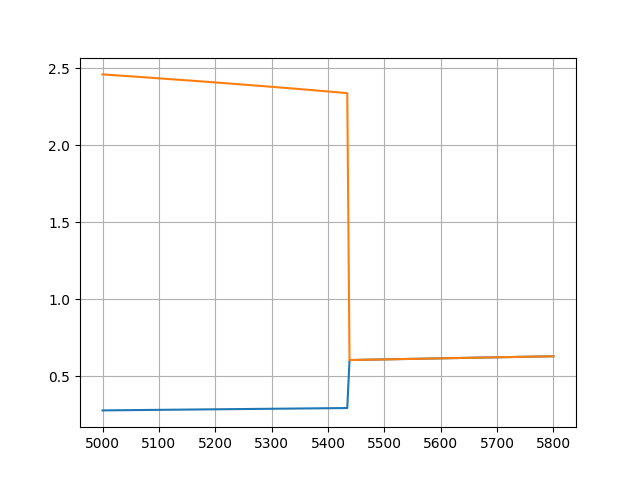

In [15]:
%matplotlib notebook

N = 200
Hs_abs = np.linspace(5.0e3, 5.8e3, N)

ang1_grid = []
ang2_grid = []

for H_abs in Hs_abs:
    H_cur = pol2cart(H_abs, np.deg2rad(63.), 0.)
    st_angs = st_state.get_angles2(film_inst, H_cur)#, N=1)
    ang1_grid.append(st_angs.min())
    ang2_grid.append(st_angs.max())
    #ang1.append(min(st_angs[0], st_angs[2]))
    #ang2.append(max(st_angs[0], st_angs[2]))

plt.plot(Hs_abs, ang1_grid)
plt.plot(Hs_abs, ang2_grid)
plt.grid(True)


<IPython.core.display.Javascript object>


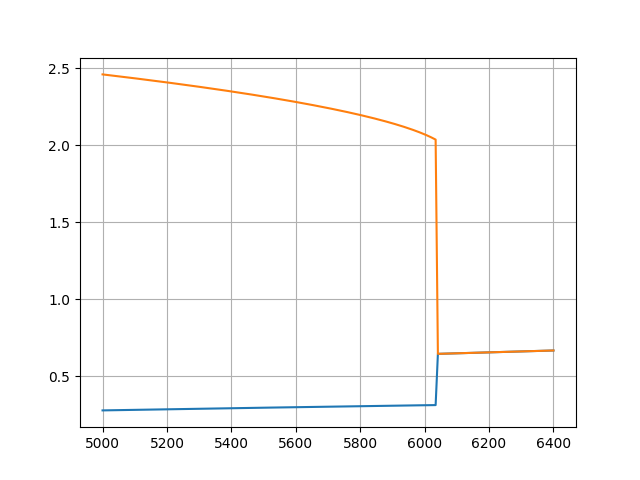

In [13]:
%matplotlib notebook

N = 200
Hs_abs = np.linspace(5.0e3, 6.4e3, N)

ang1_rand = []
ang2_rand = []

for H_abs in Hs_abs:
    H_cur = pol2cart(H_abs, np.deg2rad(63.), 0.)
    st_angs = st_state.get_angles(film_inst, H_cur, N=1)
    ang1_rand.append(min(st_angs[0], st_angs[2]))
    ang2_rand.append(max(st_angs[0], st_angs[2]))

plt.plot(Hs_abs, ang1_rand)
plt.plot(Hs_abs, ang2_rand)
plt.grid(True)

<IPython.core.display.Javascript object>


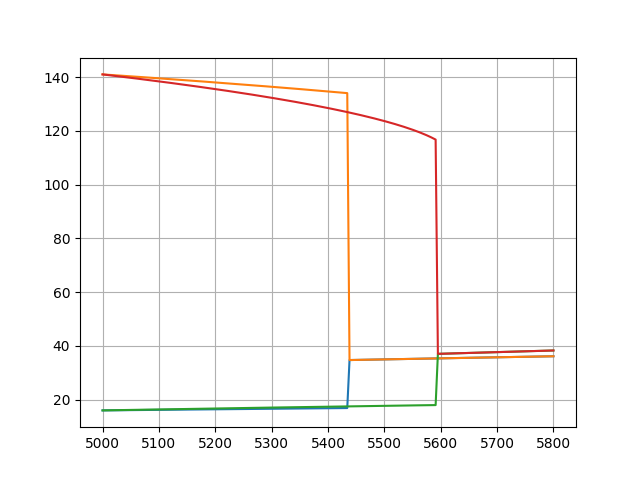

In [18]:
%matplotlib notebook
plt.plot(Hs_abs, np.rad2deg(ang1_grid))
plt.plot(Hs_abs, np.rad2deg(ang2_grid))
plt.plot(Hs_abs, np.rad2deg(ang1_rand))
plt.plot(Hs_abs, np.rad2deg(ang2_rand))
plt.grid(True)

In [ ]:
%matplotlib notebook
plt.plot(Hs_abs, np.rad2deg(ang1_grid))
plt.plot(Hs_abs, np.rad2deg(ang2_grid))
plt.scatter(Hs_abs, np.rad2deg(ang1_grid))
plt.grid(True)
plt.xlabel("H Oe")
plt.ylabel("tet")

In [ ]:
np.savetxt("angles1.csv", np.rad2deg(ang1))
np.savetxt("angles2.csv", np.rad2deg(ang2))
np.savetxt("Hs.csv", Hs_abs)

In [39]:
np.rad2deg(ang2)

array([178.02357781, 177.98893094, 177.95424719, 177.91953066,
       177.88477745, 177.84999011, 177.81516814, 177.78030917,
       177.74541705, 177.71048865, 177.67552485, 177.64052822,
       177.60549376, 177.57042542, 177.5353197 , 177.50018091,
       177.46500571, 177.42979455, 177.39454813, 177.35926562,
       177.32394811, 177.28859301, 177.25320405, 177.21777942,
       177.18231659, 177.1468215 , 177.11128936, 177.07571816,
       177.04011431, 177.00447376, 176.96879436, 176.93308091,
       176.89733077, 176.86154484, 176.82572257, 176.78986384,
       176.75396926, 176.71803641, 176.68206816, 176.64606215,
       176.61001923, 176.57394307, 176.53782634, 176.5016745 ,
       176.46548551, 176.42925899, 176.39299717, 176.35669576,
       176.32036101, 176.28398521, 176.24757523, 176.21112517,
       176.17463912, 176.13811626, 176.10155506, 176.06495592,
       176.02832164, 175.99164875, 175.95493733, 175.91818963,
       175.88140322, 175.84457904, 175.80771665, 175.77

In [6]:
st_state.Es

J*(M_x1*M_x2 + M_y1*M_y2 + M_z1*M_z2)/(sqrt(M_x1**2 + M_y1**2 + M_z1**2)*sqrt(M_x2**2 + M_y2**2 + M_z2**2)) + t1*(-H_x*M_x1 - H_y*M_y1 - H_z*M_z1 + K_u1*(M_x1**2 + M_y1**2)/(M_x1**2 + M_y1**2 + M_z1**2) + 2*pi*M_z1**2) + t2*(-H_x*M_x2 - H_y*M_y2 - H_z*M_z2 + K_u2*(M_x2**2 + M_y2**2)/(M_x2**2 + M_y2**2 + M_z2**2) + 2*pi*M_z2**2)

In [29]:
%matplotlib notebook

Hext = pol2cart(3e3, np.deg2rad(63.), 0.)
st_angs = st_state.get_angles(film_inst, Hext, N=1)
st_angs2 = st_state.get_angles2(film_inst, Hext)
print("calc angles")
display(np.rad2deg(st_angs))
display(np.rad2deg(st_angs2))

hst = st_state.get_heff1(
    film_inst, 
    pol2cart(film_inst.l1.st.Ms, st_angs[0], st_angs[1]), 
    pol2cart(film_inst.l2.st.Ms, st_angs[2], st_angs[3]),
    Hext
)/film_inst.l1.st.t

hst2 = st_state.get_heff1(
    film_inst, 
    pol2cart(film_inst.l1.st.Ms, st_angs[0], 0.), 
    pol2cart(film_inst.l2.st.Ms, st_angs[1], 0.),
    Hext
)/film_inst.l1.st.t


print('\n')
print('got angle:')
display(np.rad2deg(np.arctan(hst[0]/hst[2])))
display(np.rad2deg(np.arctan(hst2[0]/hst2[2])))
display(hst)
display(hst2)


stet1 = np.deg2rad(0.)
stet2 = np.deg2rad(180.)
print('\n')
print("")
print(np.linalg.norm(hst))

calc angles


array([  6.94695628,   0.        , 119.05301076,   0.        ])

array([  6.94732989, 119.05276157])



got angle:


6.946986902099496

66.17609023319203

array([ 202.62613247,    0.        , 1662.97639698])

array([2995.52219024,    0.        , 1322.6761927 ])




1675.2754539125963
